# Vehicle Tracking

The goals / steps of this project are the following:

* Perform a **Histogram of Oriented Gradients (HOG) feature extraction** on a labeled training set of images and train a classifier **Linear SVM classifier**
* Optionally, you can also apply a **color transform** and **append binned color features**, as well as **histograms of color**, to your HOG feature vector.
* Note: for those first two steps don't forget to **normalize your features** and **randomize a selection for training and testing**.
* Implement a **sliding-window technique** and use your trained classifier to **search for vehicles** in images.
* Run your pipeline on a **video stream** (start with the test_video.mp4 and later implement on full project_video.mp4) and **create a heat map of recurring detections** frame by frame to **reject outliers** and **follow detected vehicles**.
* **Estimate a bounding box for vehicles detected**.

In [1]:
# initial imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

---

We will train this classifer, which would classify an image as either containing or not containing a vehicle, using a dataset provided by Udacity which comes in two separate archives: [images containing cars](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [images not containing cars](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip). 

The dataset contains 17,760 color RGB images 64×64 px each, with 8,792 samples labeled as containing vehicles and 8,968 samples labeled as non-vehicles.

The procedure of this project is as follow:

1. **Extracting features** from the images of vehicles and non-vehicles
2. Training a **linear Support Vector Machine** (SVM) classifier
3. **Scanning a frame by windows of various size** that we run through the aforementioned classifier
4. **Merging individual segment detections using heatmaps**, which help reducing the number of false positives

---

## Feature extraction

Our features are a combination of **Histogram of Oriented Gradients** (HOG), **spatial information**, and **color channel histograms**. All of them are using **YCbCr** color space.

Details of the implementation is located in [features.py](features.py).

### 1. Histogram of Oriented Gradients

We're going to use HOG with **10 oritentations**, **8 pixels per cell**, and **2 pixels per block**. We choose the parameters to have the best performance on the classifier below.

```python
    def __init__(self, image, orient=9, pix_per_cell=8, cell_per_block=2):
        """
        Initialises an instance.
        """
        self.image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        (self.h, self.w, self.d) = self.image.shape
        self.hog_features = []
        self.pix_per_cell = pix_per_cell
        for channel in range(self.d):
            self.hog_features.append(
                hog(self.image[:, :, channel],
                    orientations=orient,
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block),
                    transform_sqrt=True,
                    visualise=False,
                    feature_vector=False)
            )
        self.hog_features = np.asarray(self.hog_features)
```

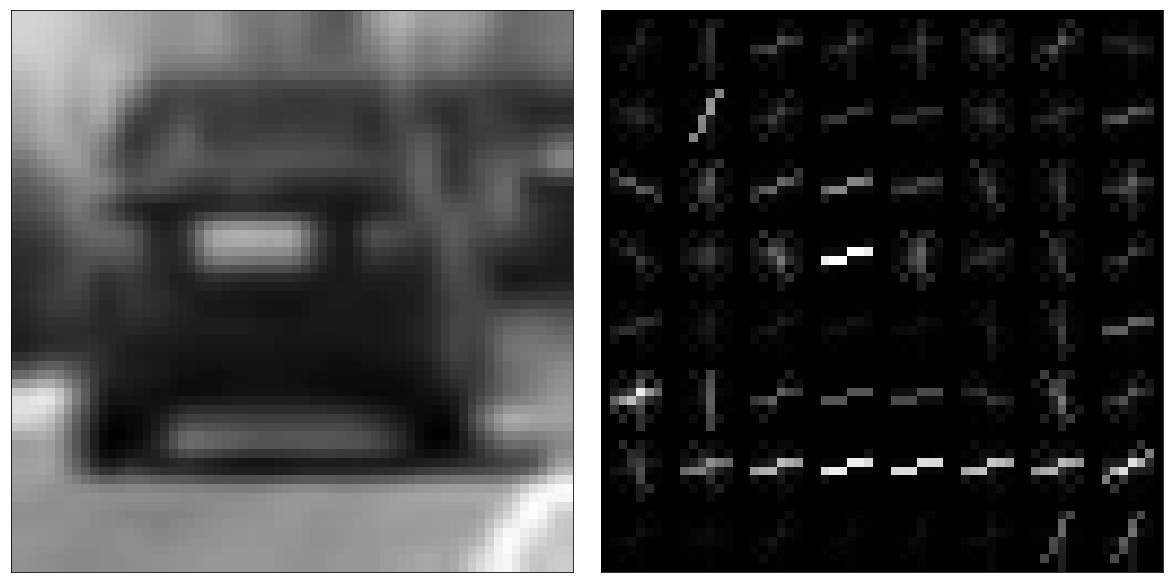

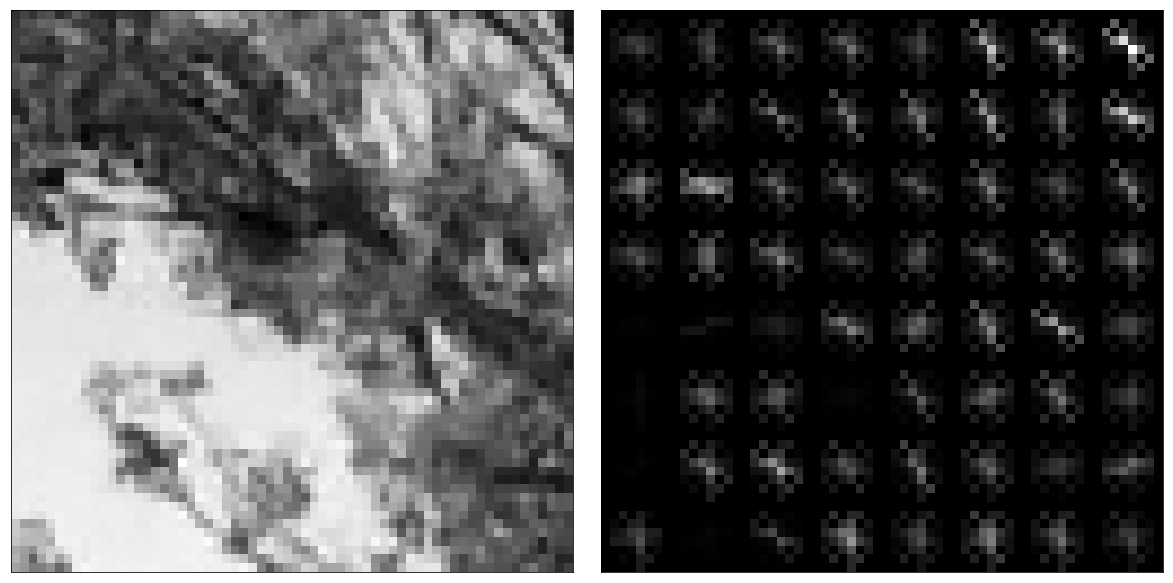

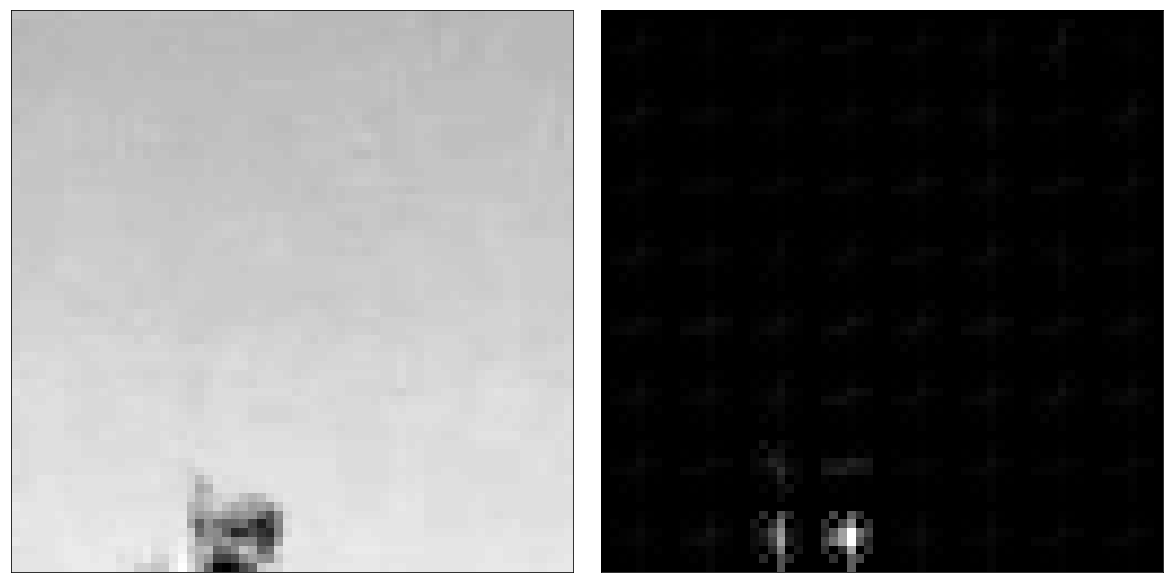

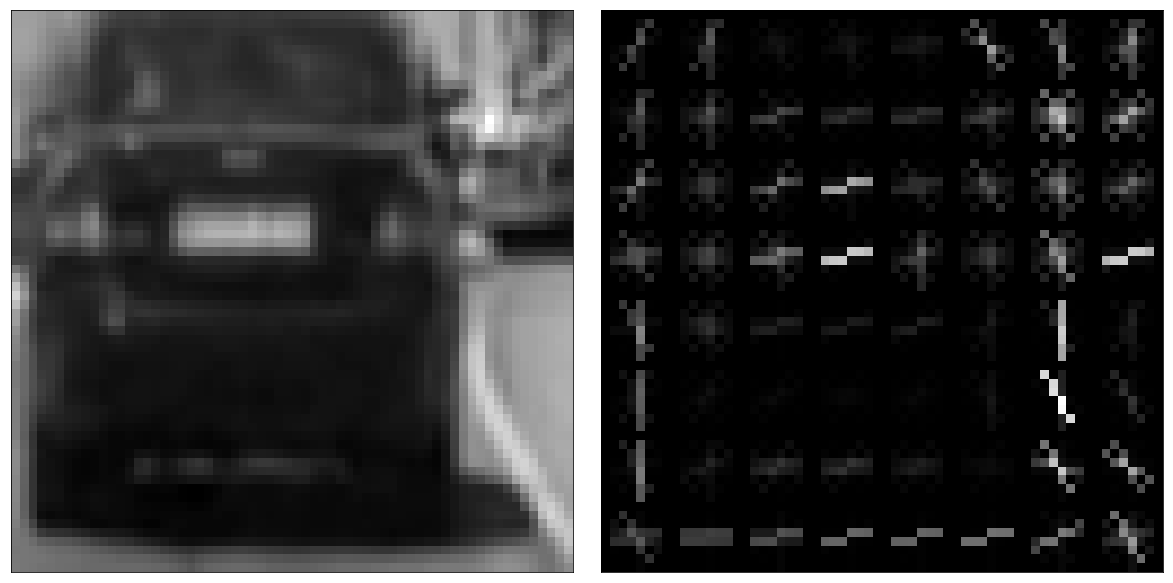

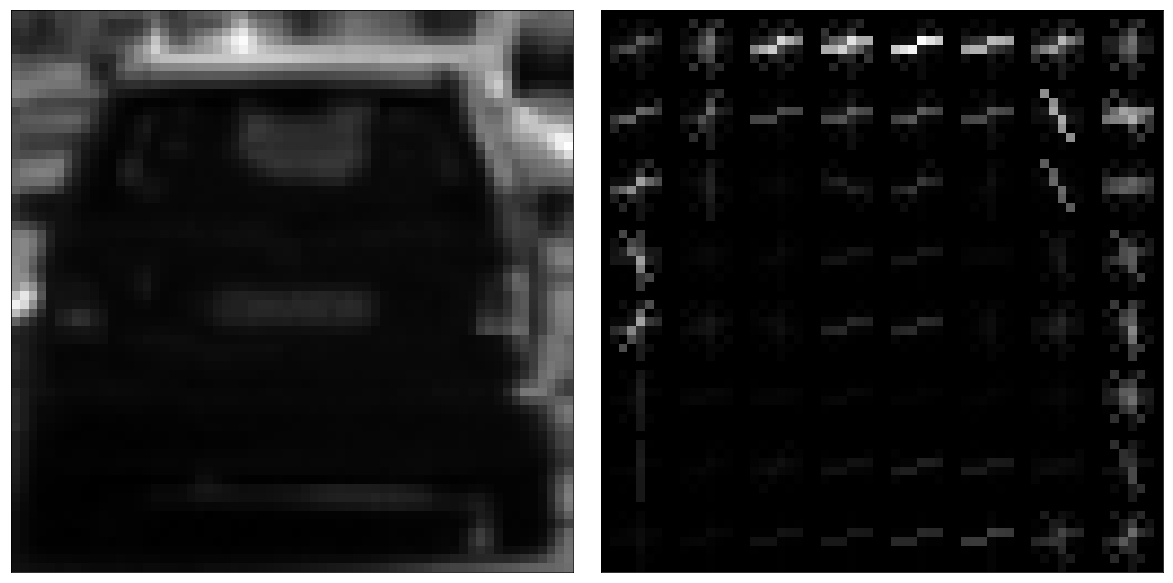

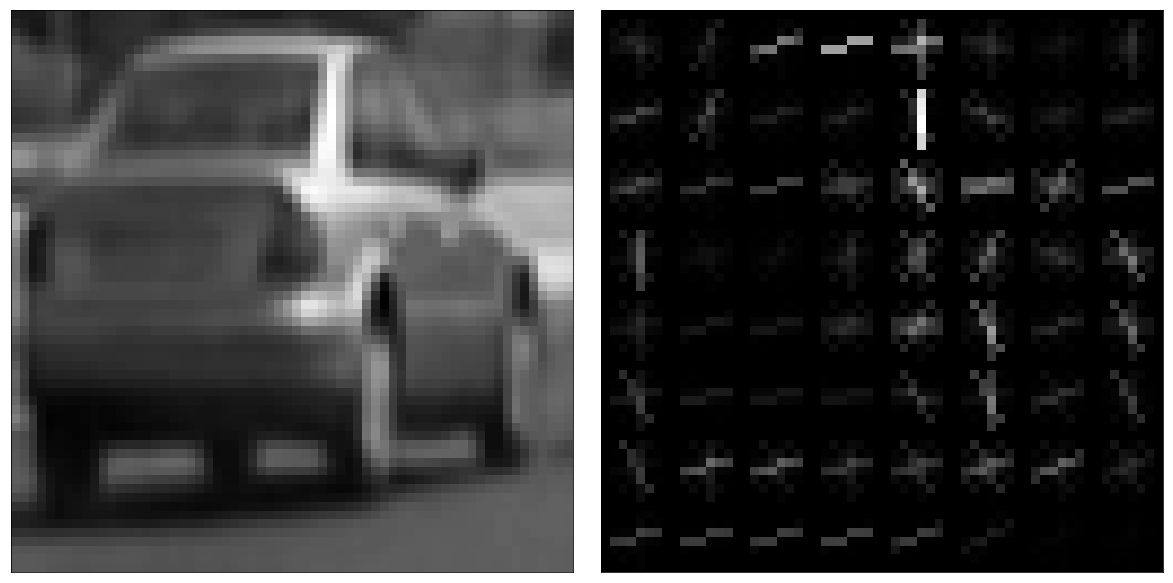

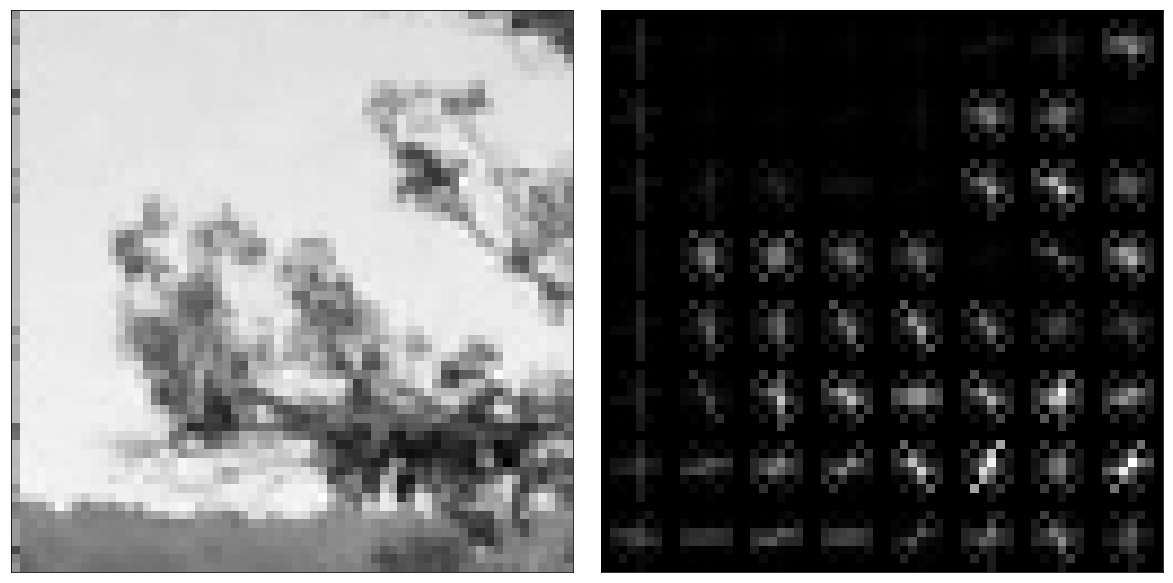

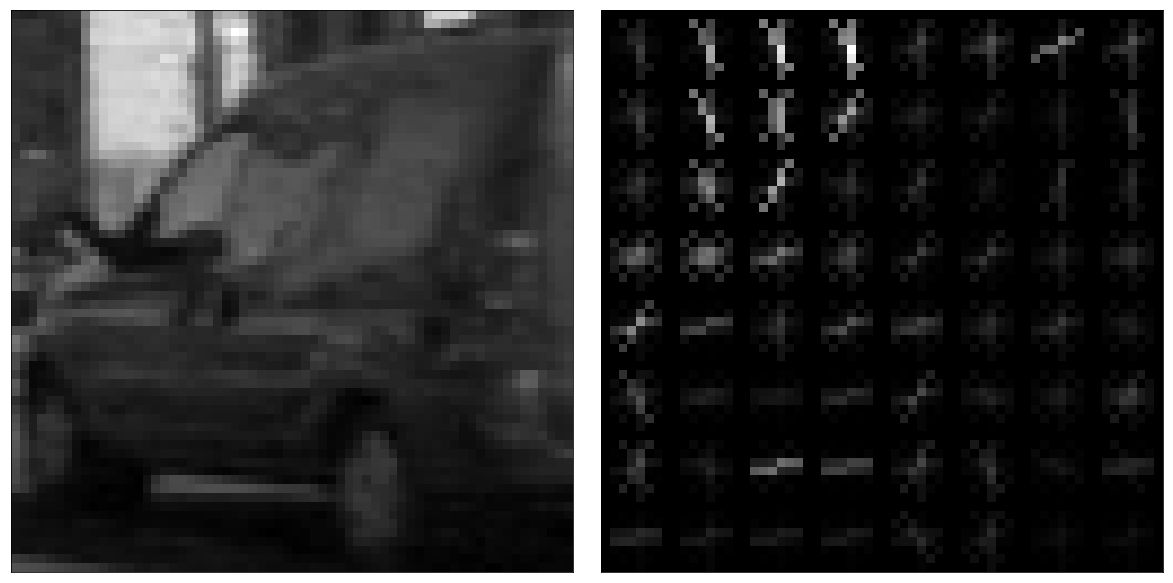

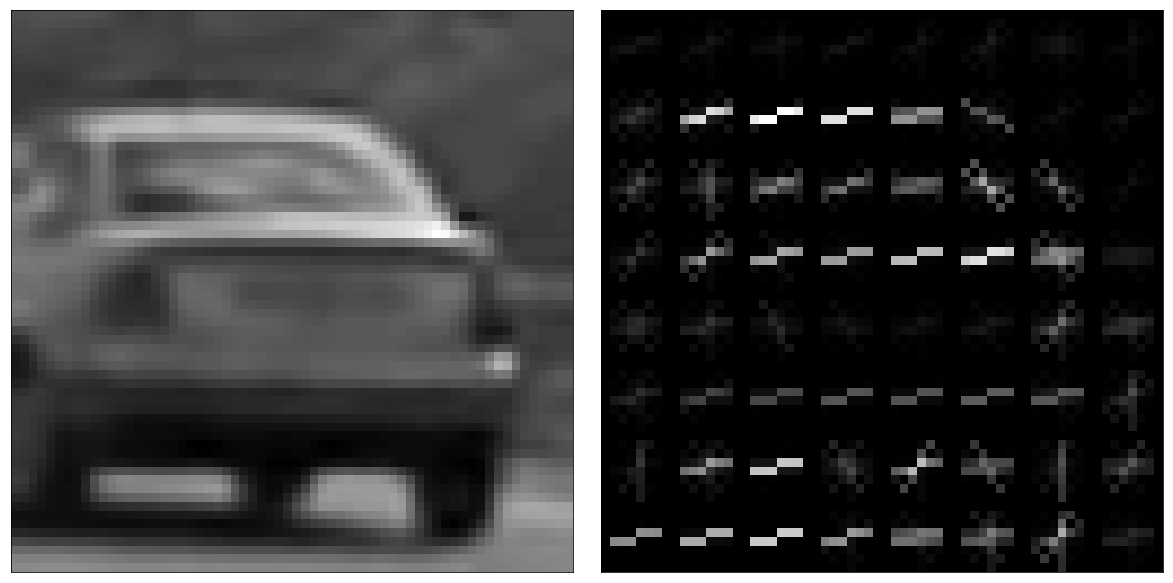

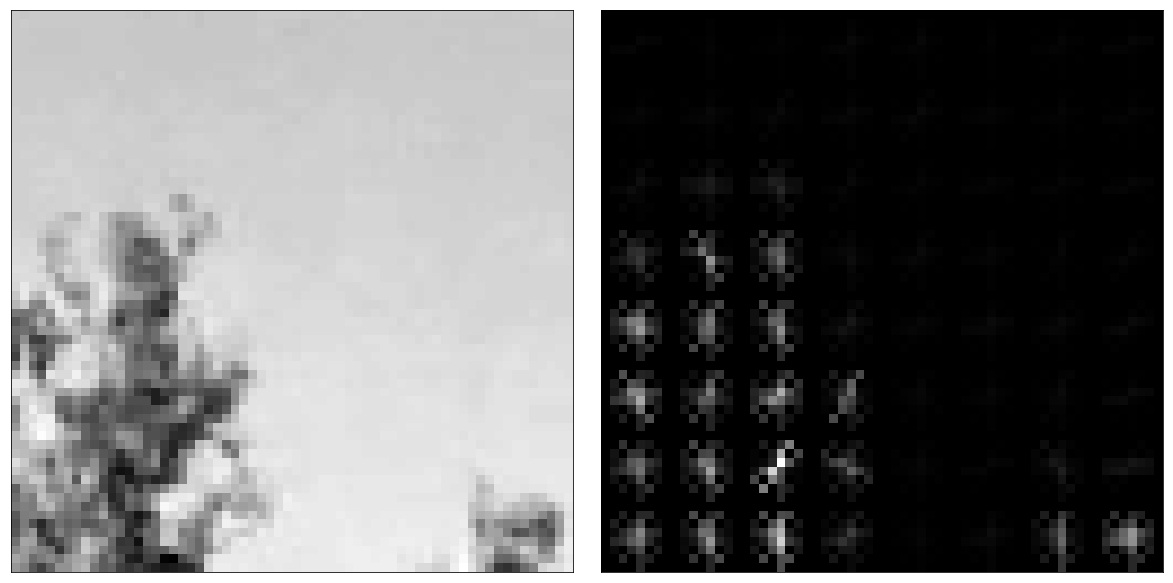

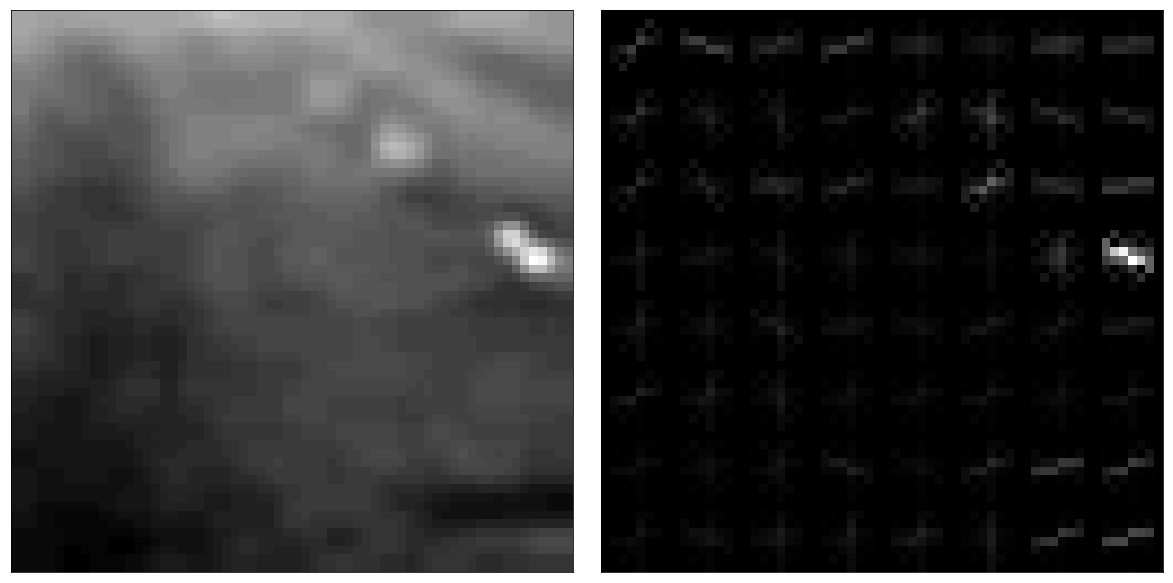

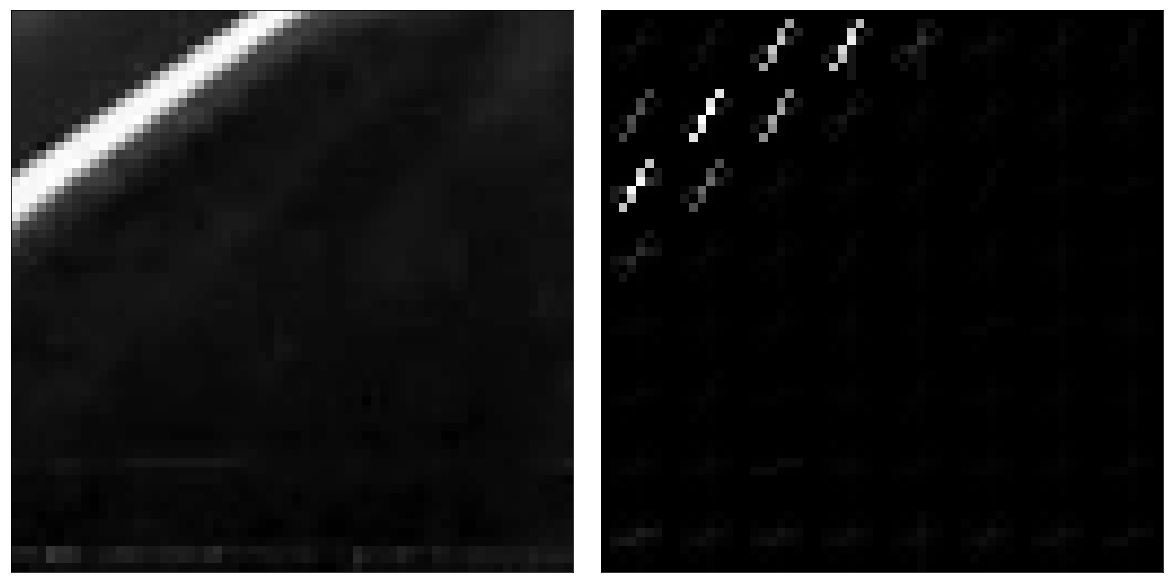

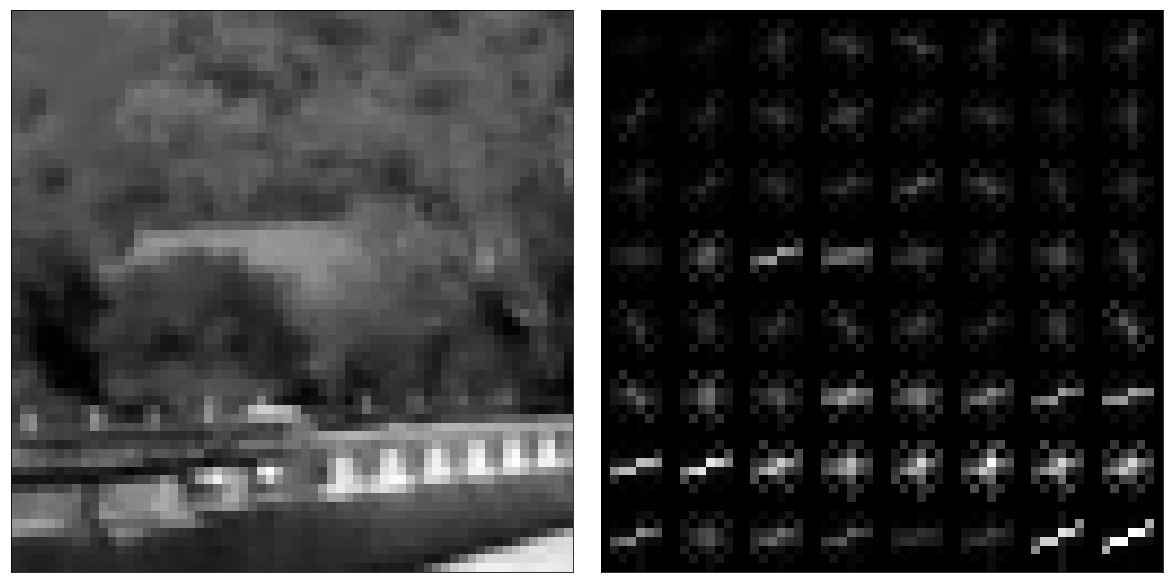

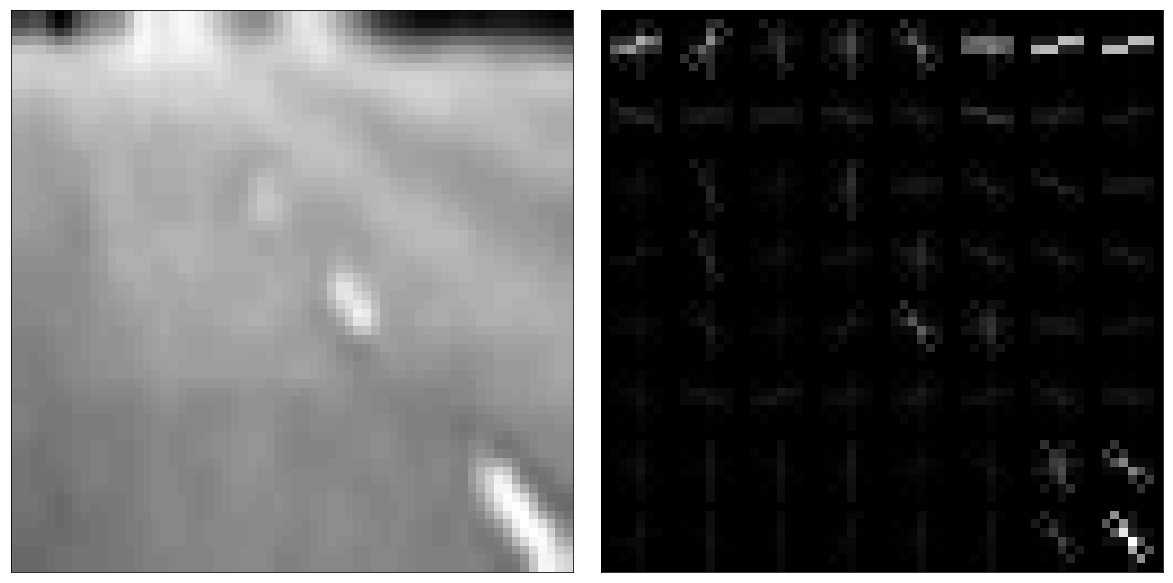

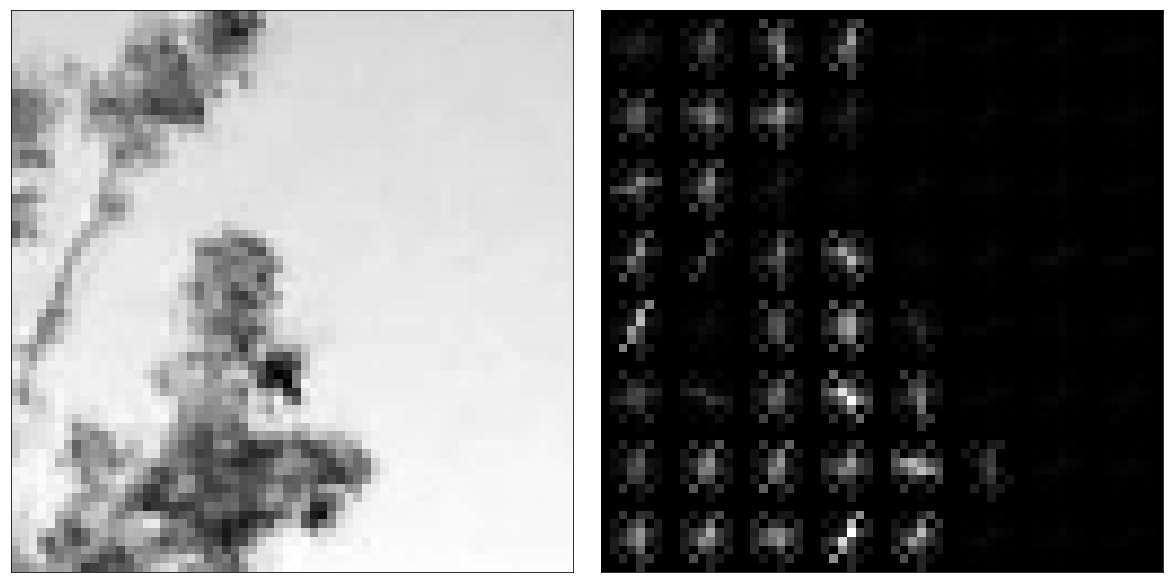

In [2]:
from skimage.feature import hog

cars_files = glob.glob('data/_random/*.png')

count = 0
for file in cars_files:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY)  # should be cv2.COLOR_RGB2YCrCb, simplify for demo
    _, hog_image = hog(image, visualise=True)
    
    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    
    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image, cmap='gray')
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(hog_image, cmap='gray')
    
    plt.show()    

### 2. Spatial information

We simply resize the image to 16×16 and flatten to a 1-D vector to get the spatial information. Nothing fancy here.

```python
    spatial = cv2.resize(image, (16, 16)).ravel()
```

### 3. Color channel histogram

For each color channel, we get its histogram information, breaking it into **16 bins** within **(0, 256)** range.

```python
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:, :, 2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
```

### 4. Feature extractor

The `FeatureExtractor` class can work both with a whole image, or a single subregion of that image. A usual scenario is that: The user initialze the feature extractor on a whole frame, then request a feature extraction for the regions of interest. The return feature_vector is a concaternated combination of HOG, spatial information, and color histogram feature vectors.

```python
    extractor = FeatureExtractor(frame)

    # Feature vector for entire frame
    feature_vector = extractor.feature_vector()

    # Feature vector for a 64×64 frame region at (0, 0) point
    feature_vector = extractor.feature_vector(0, 0, 64)
```

---

## Linear SVM Classifer

We are going to train a linear SVM classifier, which use all the features above as input. The choice of a linear SVM is pretty natural since we want to have both a good accuracy and a good speed.

The result (**accuracy**) on a validation set is **0.9873**.

We implemented the classifier in the below cell.

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from features import FeatureExtractor
from utilities import print_progress

# Read training data
print('Reading data...')
cars = []
notcars = []
notcars_files = glob.glob('data/non-vehicles/*/*.png')
cars_files = glob.glob('data/vehicles/*/*.png')
for file in cars_files:
    cars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
for file in notcars_files:
    notcars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))

cars = np.asarray(cars)    
notcars = np.asarray(notcars)    
print('    ...Done')

print('Vehicles images:', cars.shape[0])
print('Non-vehicles images:', notcars.shape[0])

# Extract features
print('Extracting features...')
car_features = []
notcar_features = []
for car in cars:
    car_features.append(FeatureExtractor(car).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
for notcar in notcars:
    notcar_features.append(FeatureExtractor(notcar).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print('    ...Done')

# Perform feature scaling
print('Scaling features...')
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('    ...Done')

# Train linear SVC classifier
print('Training classifier...')
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('    ...Done')
print('Accuracy =', accuracy)

Reading data...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Vehicles images: 8792
Non-vehicles images: 8968
Extracting features...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Scaling features...
    ...Done
Training classifier...
    ...Done
Accuracy = 0.9873


## Frame segmentation

We observe that in different regions of the frame, the size of the vehicles are different (the nearer the vehicle is to the top, the smaller it is in a frame). With that observation, we can approximate the size of the vehicle in different regions of the frame. 

![The approximated size of the vehicle in different region of the frame](assets/scanning.jpg)

Since frame segments must be of various size, and we eventually need to use 64×64 regions as a classifier input, we can simply scale the frame to various sizes and then scan them with a 64×64 window. The logic can be shown as below.

```python
    def detect_vehicles(self, image):
        """
        Perform a full window passthrough in the specified frame.
        """
        scales = np.array([.3, .5, .65, .8])
        y_top = np.array([.6, .57, .56, .55])
        frame_detections = np.empty([0, 4], dtype=np.int64)
        for scale, y in zip(scales, y_top):
            scale_detections = self.detections_for_scale(image, scale, y, 64)
            frame_detections = np.append(
                frame_detections, scale_detections, axis=0)
        detections, self.heatmap = self.merge_detections(
            frame_detections, image.shape, threshold=1)
        self.detections_history.append(detections)
```

---

## Merging segmented detections

We are about to merge nearby detections since there are a lot of detections on different scales and the scanning windows are overlapped to each other. In order to do that, we calculate a heatmap of intersecting regions that were classified as containing vehicles.

```python
    def add_heat(self, heatmap, coordinates):
        """
        Adds "1" for pixels inside each detected region.
        """
        for c in coordinates:
            # Assuming each set of coordinates takes the form (x1, y1, x2, y2)
            heatmap[c[1]:c[3], c[0]:c[2]] += 1
        return heatmap
```

After getting the heatmap, we eliminate all the region that have the 'active level' lower than a threshold. We use `label()` function from `scipy.ndimage.measurements` module to detect individual groups of detections, and to calculate the boundary of the detected group.

```python
    def merge_detections(self, detections, image_shape, threshold):
        """
        Merges specified detections based on a heatmap and threshold.
        Parameters
        """
        heatmap = np.zeros((image_shape[0], image_shape[1])).astype(np.float)

        # Add heat to each box in box list
        heatmap = self.add_heat(heatmap, detections)

        # Apply threshold to help remove false positives
        heatmap[heatmap < threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        cars = np.empty([0, 4], dtype=np.int64)

        # Iterate through all detected cars
        for car in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car).nonzero()
            cars = np.append(
                cars,
                [[np.min(nonzero[1]), np.min(nonzero[0]),
                  np.max(nonzero[1]), np.max(nonzero[0])]],
                axis=0
            )

        # Return the image
        return (cars, heatmap)
```

The result is shown as below.

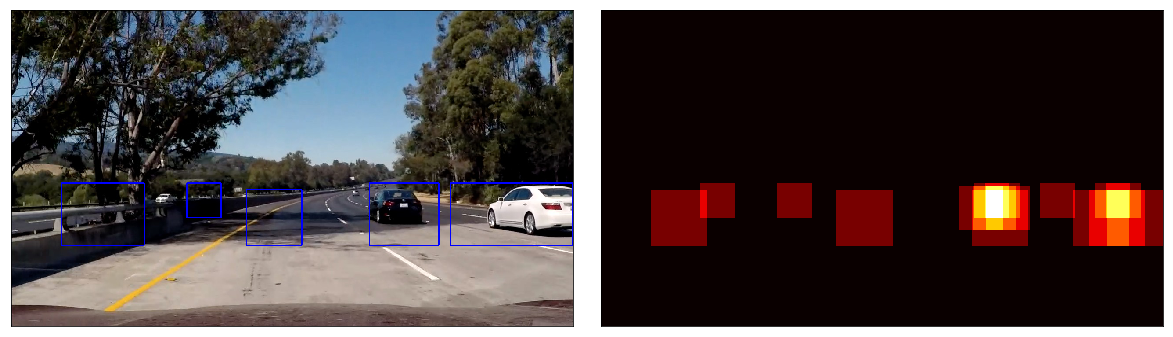

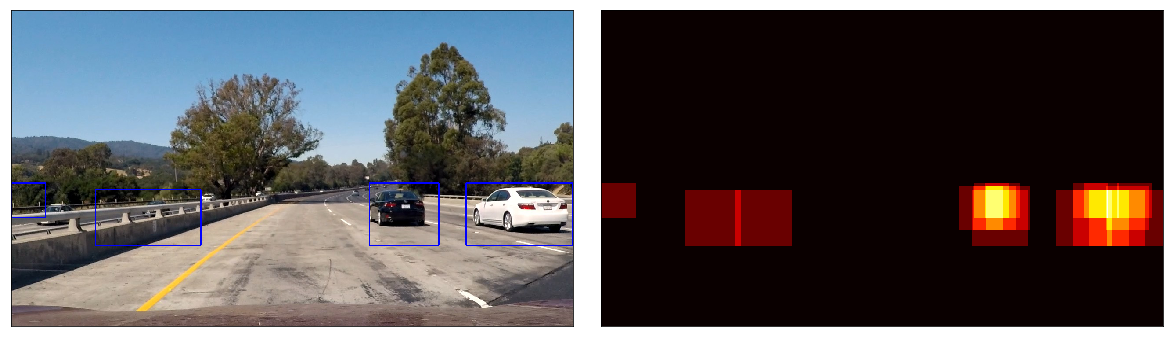

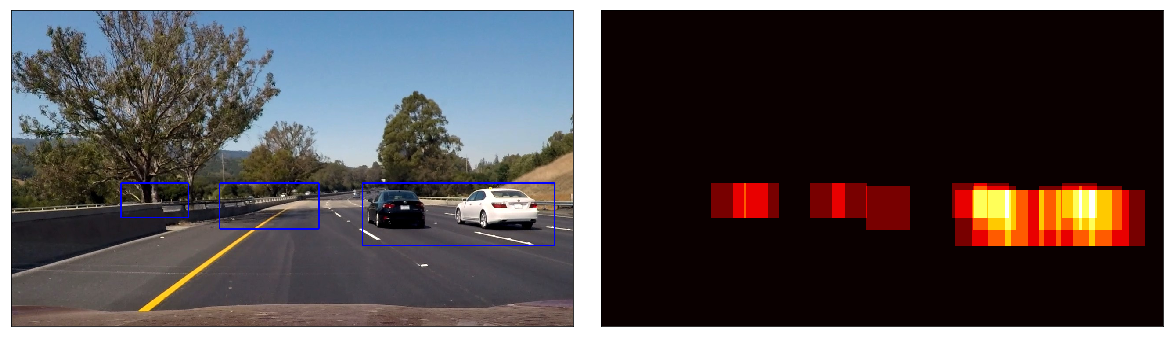

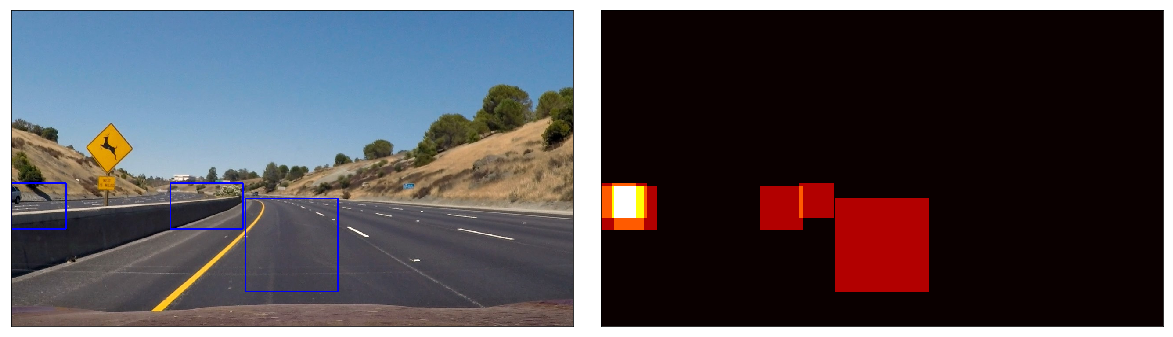

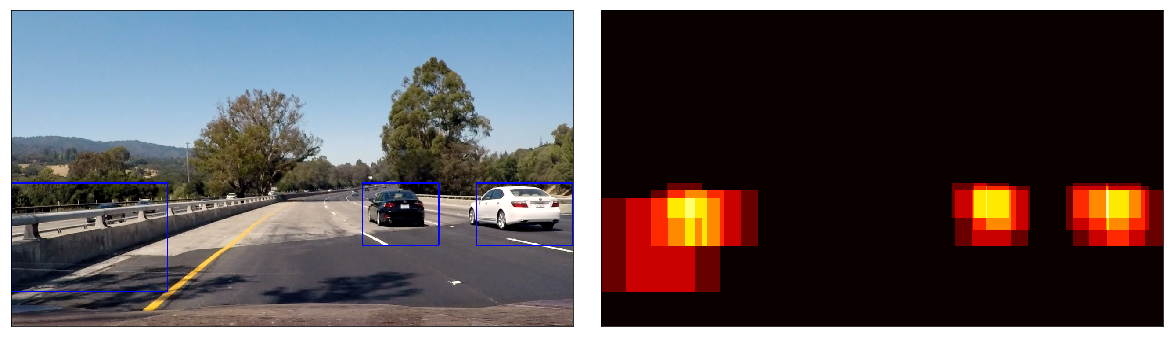

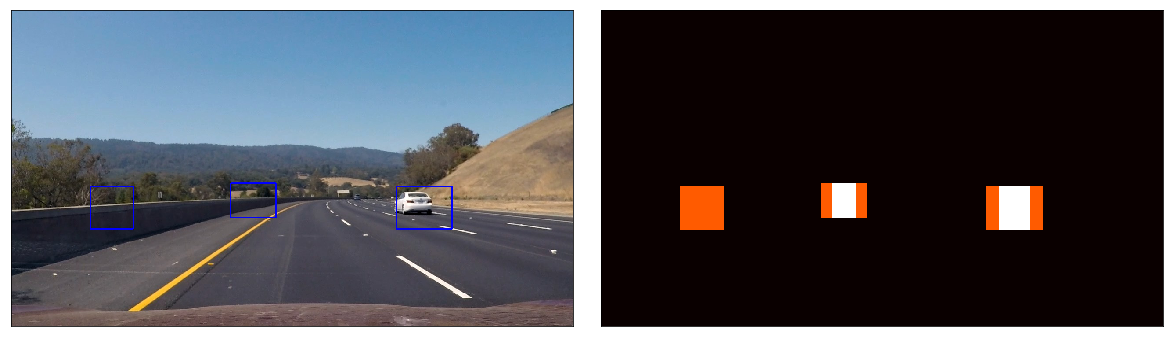

In [4]:
from tracker import VehicleTracker

for image_name in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_name)
    tracker = VehicleTracker(X_scaler, svc, image)
    tracker.process(image, draw_detections=True)

    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(tracker.heatmap, cmap='hot')
    plt.show()

## Applying pipeline to video

We apply our pipeline into the video with some adaptations:

1. Accumulating detections over last N frames instead of classifying each frame individually
2. Running those accumulated detections through the heatmap merging process once again, before returning a final set of detected regions, with a higher detection threshold

In [5]:
from moviepy.editor import VideoFileClip
from tracker import VehicleTracker

video_output_name = 'video/project_video_annotated_vehicles.mp4'
video = VideoFileClip("video/project_video.mp4")
tracker = VehicleTracker(X_scaler, svc, video.get_frame(0))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video video/project_video_annotated_vehicles.mp4
[MoviePy] Writing video video/project_video_annotated_vehicles.mp4


100%|█████████▉| 1260/1261 [44:14<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/project_video_annotated_vehicles.mp4 

CPU times: user 47min 2s, sys: 15min 56s, total: 1h 2min 58s
Wall time: 44min 15s


In [2]:
from IPython.display import HTML

video_output_name = 'video/project_video_annotated_vehicles.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output_name))

In [9]:
video_output_name = 'video/test_video_annotated.mp4'
video = VideoFileClip("video/test_video.mp4")
tracker = VehicleTracker(X_scaler, svc, video.get_frame(0))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video video/test_video_annotated.mp4
[MoviePy] Writing video video/test_video_annotated.mp4


 97%|█████████▋| 38/39 [01:14<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/test_video_annotated.mp4 

CPU times: user 1min 20s, sys: 29.6 s, total: 1min 49s
Wall time: 1min 15s


In [3]:
from IPython.display import HTML

video_output_name = 'video/test_video_annotated.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output_name))

There are many drawbacks of our approach:

1. **Too slow.** The process speed is < 2 frames / sec, which makes this can't be applied into real-life situation. The **state-of-the-art methods** are [**SSD**](https://arxiv.org/abs/1512.02325) and [**YOLO/Fast YOLO**](https://arxiv.org/abs/1506.02640) can process more than 50 frames in one single second.

2. The classifier still **fails to segment the vehicles on the opposite side**, or **not perform well** when our vehicle is **blocked by another vehicle** (or **vehicles obstructing each other**).